In [1]:
!python -m pip install flowMC

  Using cached jax-0.4.26-py3-none-any.whl.metadata (23 kB)
  Using cached equinox-0.11.4-py3-none-any.whl.metadata (18 kB)
  Using cached optax-0.2.2-py3-none-any.whl.metadata (8.1 kB)
  Using cached evosax-0.1.6-py3-none-any.whl.metadata (26 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached jaxtyping-0.2.28-py3-none-any.whl.metadata (6.4 kB)
  Using cached chex-0.1.86-py3-none-any.whl.metadata (17 kB)
  Using cached flax-0.8.2-py3-none-any.whl.metadata (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
  Using cached dotmap-1.3.30-py3-none-any.whl.metadata (3.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.4 MB/s eta 0:00:00
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached toolz-0.12.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl.metadata (3.6 kB)
  Using cached cyc

In [45]:
import jax
import jax.numpy as jnp
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.proposal.MALA import MALA
from flowMC.Sampler import Sampler
import numpy as np
from jax import random
from jax.scipy.stats import norm

# def log_posterior(x, data: dict):
#     return -0.5 * jnp.sum((x - data['data']) ** 2)

#data = {'data':jnp.arange(5)}
# data = {'data': jnp.array([-1, 8])}

def log_posterior(x, data: dict):
    # Extract modes and scales from the data dictionary
    mode1 = data['data'][0]
    mode2 = data['data'][1]
    
    # Compute the mixture of two Gaussian probability density functions
    pdf1 = norm.pdf(x, loc=mode1, scale=0.2)
    pdf2 = norm.pdf(x, loc=mode2, scale=0.3)
    
    # Take the log of the sum of the two Gaussian PDFs
    return jnp.sum(jnp.log(pdf1 + pdf2))

data = {'data': jnp.array([-1, 8])}

In [83]:
# pip install tensorflow
# pip install tensorflow_probability
# pip install tensorflow-probability[tf]
import tensorflow as tf
import tensorflow_probability as tfp
from typing import Callable, Tuple

import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jrnd
from jax.flatten_util import ravel_pytree

def stein_disc(X, logprob_fn, beta=-1/2) -> Tuple:
    """Stein discrepancy with inverse multi-quadric kernel,
    i.e. (1 + (x - x')T(x - x')) ** beta
    returns U-Statistic (unbiased) and V-statistic (biased)
    """

    X = jax.tree_map(lambda x: x.reshape((-1,) + x.shape[2:]), X)
    if isinstance(X, dict):
        d = 0
        for name, x in X.items():
            s = x.shape
            if not s[1:]:
                d += 1
            else:
                d += s[1]
        T = s[0]
        sub = lambda x, x_: ravel_pytree(x)[0] - ravel_pytree(x_)[0]
        grad = lambda x: ravel_pytree(jax.grad(logprob_fn)(x))[0]
    else: 
        T, d = X.shape
        sub = lambda x, x_: x - x_
        grad = jax.grad(logprob_fn)
    beta = -beta

    def disc(x, x_):
        diff = sub(x, x_)
        dot_prod = jnp.dot(diff, diff)
        dx = grad(x)
        dx_ = grad(x_)
        return (
            -4 * beta * (beta+1) * dot_prod / ((1 + dot_prod) ** (beta + 2))
            + 2 * beta * (d + jnp.dot(dx - dx_, diff)) / ((1 + dot_prod) ** (1 + beta))
            + jnp.dot(dx, dx_) / ((1 + dot_prod) ** beta)
        )

    _disc = jax.vmap(disc, (None, 0))
    mc_sum = jax.lax.map(lambda x: _disc(x, X).sum(), X).sum()
    return (mc_sum - jax.vmap(lambda x: disc(x, x))(X).sum()) / (T * (T-1)), mc_sum / T**2

def autocorrelation(x, axis=0):
    """
    Computes the autocorrelation of samples at dimension ``axis``.

    :param numpy.ndarray x: the input array.
    :param int axis: the dimension to calculate autocorrelation.
    :return: autocorrelation of ``x``.
    :rtype: numpy.ndarray
    """
    # Ref: https://en.wikipedia.org/wiki/Autocorrelation#Efficient_computation
    # Adapted from Stan implementation
    # https://github.com/stan-dev/math/blob/develop/stan/math/prim/mat/fun/autocorrelation.hpp
    N = x.shape[axis]
    M = _fft_next_fast_len(N)
    M2 = 2 * M

    # transpose axis with -1 for Fourier transform
    x = np.swapaxes(x, axis, -1)

    # centering x
    centered_signal = x - x.mean(axis=-1, keepdims=True)

    # Fourier transform
    freqvec = np.fft.rfft(centered_signal, n=M2, axis=-1)
    # take square of magnitude of freqvec (or freqvec x freqvec*)
    freqvec_gram = freqvec * np.conjugate(freqvec)
    # inverse Fourier transform
    autocorr = np.fft.irfft(freqvec_gram, n=M2, axis=-1)

    # truncate and normalize the result, then transpose back to original shape
    autocorr = autocorr[..., :N]
    # autocorr = autocorr / np.arange(N, 0.0, -1)
    with np.errstate(invalid="ignore", divide="ignore"):
        autocorr = autocorr / autocorr[..., :1] / 2
    return np.swapaxes(autocorr, axis, -1)

def _fft_next_fast_len(target):
    # find the smallest number >= N such that the only divisors are 2, 3, 5
    # works just like scipy.fftpack.next_fast_len
    if target <= 2:
        return target
    while True:
        m = target
        while m % 2 == 0:
            m //= 2
        while m % 3 == 0:
            m //= 3
        while m % 5 == 0:
            m //= 5
        if m == 1:
            return target
        target += 1

In [132]:
import scipy.integrate

Z = scipy.integrate.quad(lambda x: np.exp(log_posterior(x, data)), -5, 10)
Z

(2.0000001097910736, 2.482530774484055e-08)

In [133]:
n_dim = 1
n_chains = 10

rng_key = jax.random.PRNGKey(0)
rng_key, subkey = jax.random.split(rng_key)
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dim)) * 1
rng_key, subkey = jax.random.split(rng_key)
model = MaskedCouplingRQSpline(n_dim, 3, [64, 64], 8, subkey)
step_size = 1e-1
local_sampler = MALA(log_posterior, True, step_size=step_size)

nf_sampler = Sampler(
    n_dim,
    rng_key,
    data,
    local_sampler,
    model,
    n_local_steps=400,
    n_global_steps=100,
    n_epochs=50,
    learning_rate=1e-3,
    batch_size=10000,
    n_chains=n_chains,
)

nf_sampler.sample(initial_position, data)
chains, log_prob, local_accs, global_accs = nf_sampler.get_sampler_state().values()

['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


Global Tuning:   0%|                                      | 0/3 [00:00<?, ?it/s]

Compiling MALA body


Global Sampling: 100%|████████████████████████████| 3/3 [00:00<00:00, 33.79it/s]


In [134]:
merging = chains.flatten()

In [138]:
nf_sampler_m = Sampler(
    n_dim,
    rng_key,
    data,
    local_sampler,
    model,
    n_local_steps=500,
    n_global_steps=0,
    n_epochs=50,
    learning_rate=1e-3,
    batch_size=10000,
    n_chains=n_chains,
)

nf_sampler_m.sample(initial_position, data)
chains_m, log_prob, local_accs, global_accs = nf_sampler_m.get_sampler_state().values()

['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


Global Sampling: 100%|████████████████████████████| 3/3 [00:00<00:00, 41.13it/s]


In [136]:
merging_m = chains_m.flatten()

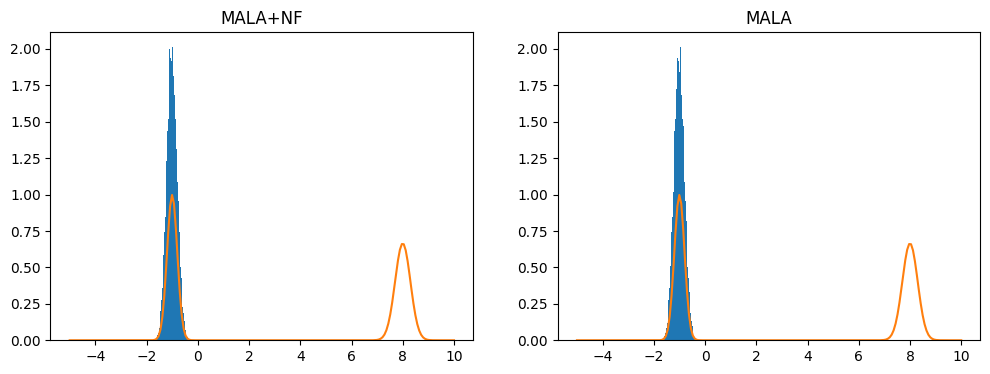

In [139]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the histogram and the density plot for merging_prior
axs[0].hist(merging, 50, density=True)
t = np.linspace(-5, 10, 200)
y_values = []
for i in range(len(t)):
    y_values.append(np.exp(log_posterior(t[i], data))) 

y_values = np.array(y_values)
axs[0].plot(t, y_values / Z[0])
axs[0].set_title('MALA+NF')

# Plot the histogram and the density plot for merging_mala
axs[1].hist(merging_m, 50, density=True)
axs[1].plot(t, y_values / Z[0])
axs[1].set_title('MALA')

plt.show()

In [72]:
import jax.numpy as jnp
import jax

n_dim = 1
n_chains = 10

rng_key = jax.random.PRNGKey(0)
rng_key, subkey = jax.random.split(rng_key)
# Generate the initial positions for all chains
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dim)) * 1

new_initial_position = jnp.concatenate((jnp.full((5, 1), -1, dtype=jnp.float32),
                             jnp.full((5, 1), 8, dtype=jnp.float32)))

In [73]:
new_initial_position

Array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.]], dtype=float32)

In [74]:
# MALA+NF
nf_sampler_prior = Sampler(
    n_dim,
    rng_key,
    data,
    local_sampler,
    model,
    n_local_steps=400,
    n_global_steps=100,
    n_epochs=50,
    learning_rate=1e-3,
    batch_size=10000,
    n_chains=n_chains,
)

nf_sampler_prior.sample(new_initial_position, data)
chains_prior, log_prob, local_accs, global_accs = nf_sampler_prior.get_sampler_state().values()

['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


Global Sampling: 100%|████████████████████████████| 3/3 [00:00<00:00, 35.79it/s]


In [131]:
merging_prior = chains_prior.flatten()

In [76]:
# MALA
nf_sampler_mala = Sampler(
    n_dim,
    rng_key,
    data,
    local_sampler,
    model,
    n_local_steps=500,
    n_global_steps=0,
    n_epochs=50,
    learning_rate=1e-3,
    batch_size=10000,
    n_chains=n_chains,
)

nf_sampler_mala.sample(new_initial_position, data)
chains_mala, log_prob, local_accs, global_accs = nf_sampler_mala.get_sampler_state().values()

['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


Global Sampling: 100%|████████████████████████████| 3/3 [00:00<00:00, 38.48it/s]


In [142]:
merging_mala = chains_mala.flatten()

In [144]:
chains_mala[0].flatten()

Array([-1.1090341, -0.8924416, -0.8525368, ..., -1.2144651, -1.2611457,
       -1.0578427], dtype=float32)

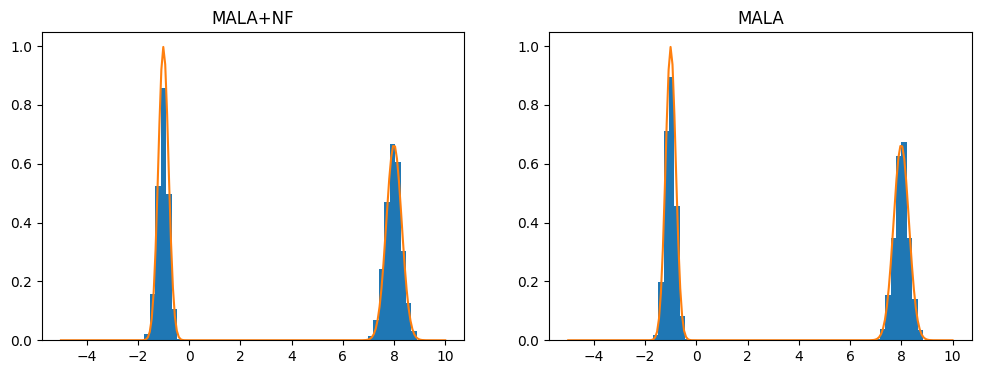

In [129]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the histogram and the density plot for merging_prior
axs[0].hist(merging_prior, 50, density=True)
t = np.linspace(-5, 10, 200)
y_values = []
for i in range(len(t)):
    y_values.append(np.exp(log_posterior(t[i], data))) 

y_values = np.array(y_values)
axs[0].plot(t, y_values / Z[0])
axs[0].set_title('MALA+NF')

# Plot the histogram and the density plot for merging_mala
axs[1].hist(merging_mala, 50, density=True)
axs[1].plot(t, y_values / Z[0])
axs[1].set_title('MALA')

plt.show()

In [80]:
autoCorr_prior = autocorrelation(merging_prior)
sum(autoCorr_prior)

0.25000000000133327

In [96]:
autoCorr_prior

array([ 5.00000000e-01,  4.37582886e-01,  4.11966047e-01, ...,
       -4.49000820e-05, -9.05151370e-06,  2.54195874e-05])

In [97]:
autoCorr_mala

array([ 5.00000000e-01,  4.99771553e-01,  4.99558140e-01, ...,
       -9.30123744e-05, -6.34658764e-05, -3.26725707e-05])

In [82]:
autoCorr_mala = autocorrelation(merging_mala)
sum(autoCorr_mala)

0.2500000000079652

In [91]:
n = len(merging_prior) # 15000
print(n)

15000


In [92]:
len(merging_mala) # 15000

15000

In [93]:
ess_mala_nf = n / (1 + 2 * sum(autoCorr_prior))
ess_mala = n / (1 + 2 * sum(autoCorr_mala))
print(ess_mala_nf)
print(ess_mala)

9999.999999982223
9999.999999893798


In [99]:
np.mean(merging_prior)

Array(3.8311172, dtype=float32)

In [98]:
np.mean(merging_mala)

Array(3.4974005, dtype=float32)

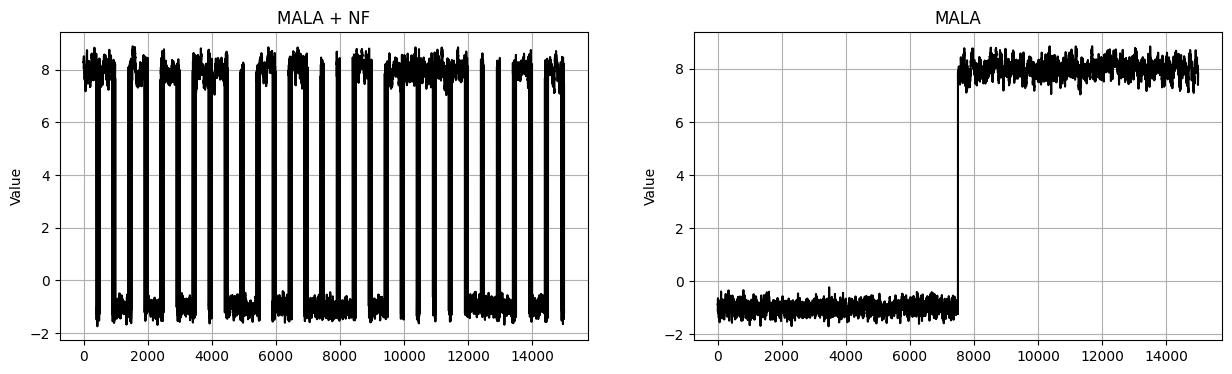

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# Plot the first trace plot
axs[0].plot(merging_prior, color='k', linestyle='-')
# axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Value')
axs[0].set_title('MALA + NF')
axs[0].grid(True)

# Plot the second trace plot
axs[1].plot(merging_mala, color='k', linestyle='-')
# axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Value')
axs[1].set_title('MALA')
axs[1].grid(True)

plt.show()

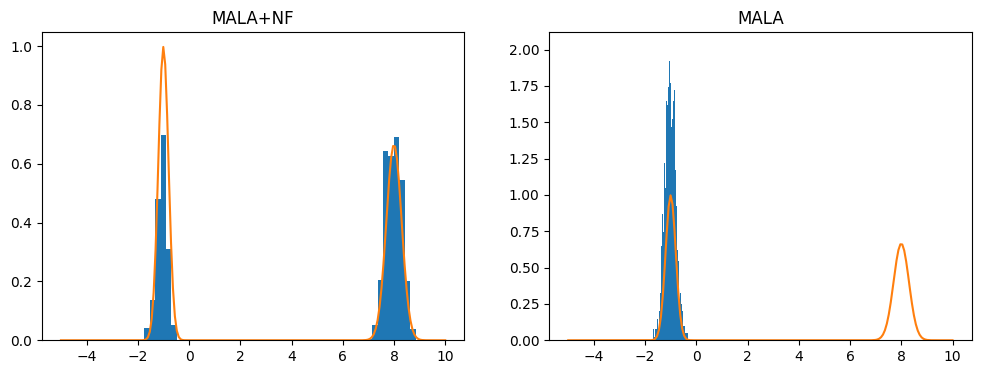

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the histogram and the density plot for merging_prior
axs[0].hist(chains_prior[0].flatten(), 50, density=True)
t = np.linspace(-5, 10, 200)
y_values = []
for i in range(len(t)):
    y_values.append(np.exp(log_posterior(t[i], data))) 

y_values = np.array(y_values)
axs[0].plot(t, y_values / Z[0])
axs[0].set_title('MALA+NF')

# Plot the histogram and the density plot for merging_mala
axs[1].hist(chains_mala[0].flatten(), 50, density=True)
axs[1].plot(t, y_values / Z[0])
axs[1].set_title('MALA')

plt.show()

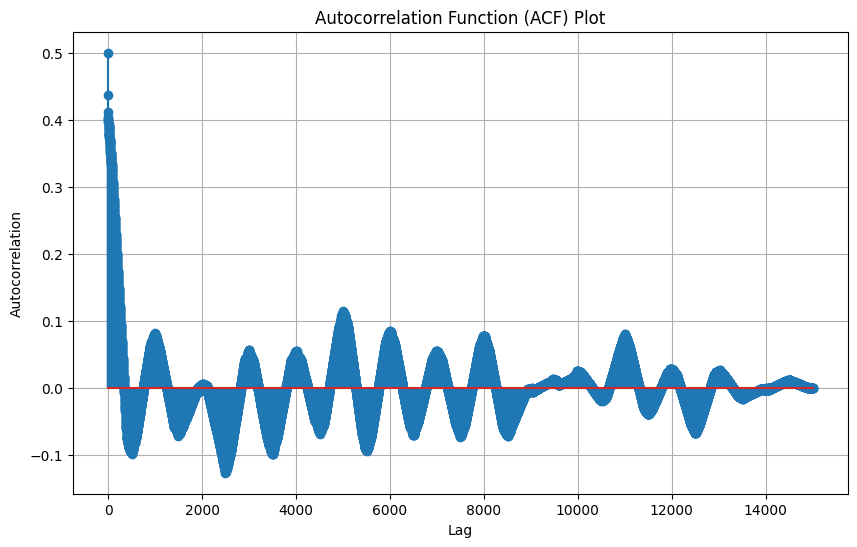

In [101]:
plt.figure(figsize=(10, 6))
plt.stem(autoCorr_prior)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.grid(True)
plt.show()

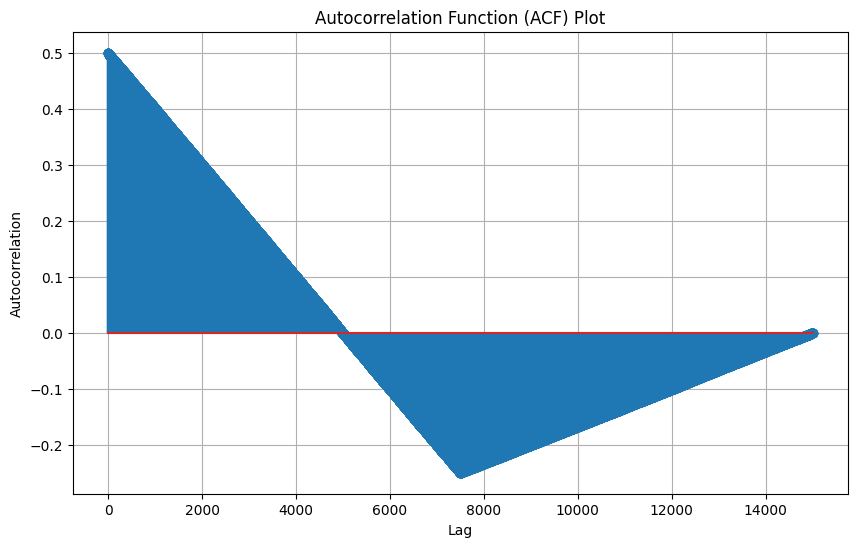

In [102]:
plt.figure(figsize=(10, 6))
plt.stem(autoCorr_mala)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.grid(True)
plt.show()

In [107]:
pip install statsmodels

/home/yangl35/.pyenv/versions/3.10.0/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 30.9 MB/s eta 0:00:00m eta 0:00:01:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 31.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [110]:
# from pandas import read_csv
# from statsmodels.graphics.tsaplots import plot_acf
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# plot_acf(autoCorr_mala, lags=50)

In [103]:
autoCorr_mala

array([ 5.00000000e-01,  4.99771553e-01,  4.99558140e-01, ...,
       -9.30123744e-05, -6.34658764e-05, -3.26725707e-05])

In [86]:
stein_disc(merging_prior, log_posterior, beta=-1/2)

/tmp/ipykernel_36656/603786271.py:21: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  X = jax.tree_map(lambda x: x.reshape((-1,) + x.shape[2:]), X)


ValueError: not enough values to unpack (expected 2, got 1)

In [7]:
# Gaussian

def log_posterior(x, data: dict):
    return -0.5 * jnp.sum((x - data['data']) ** 2)


data = {'data':jnp.arange(5)}

n_dim = 1
n_chains = 10

rng_key = jax.random.PRNGKey(0)
rng_key, subkey = jax.random.split(rng_key)
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dim)) * 1
rng_key, subkey = jax.random.split(rng_key)
model = MaskedCouplingRQSpline(n_dim, 3, [64, 64], 8, subkey)
step_size = 1e-1
local_sampler = MALA(log_posterior, True, step_size=step_size)

nf_sampler = Sampler(
    n_dim,
    rng_key,
    data,
    local_sampler,
    model,
    n_local_steps=550,
    n_global_steps=0,
    n_epochs=50,
    learning_rate=1e-3,
    batch_size=10000,
    n_chains=n_chains,
)

nf_sampler.sample(initial_position, data)
chains_mala, log_prob, local_accs, global_accs = nf_sampler.get_sampler_state().values()

['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


Global Tuning:   0%|                                      | 0/3 [00:00<?, ?it/s]

Compiling MALA body


Global Sampling: 100%|████████████████████████████| 3/3 [00:00<00:00, 45.88it/s]


In [8]:
len(chains_mala[0])

1650

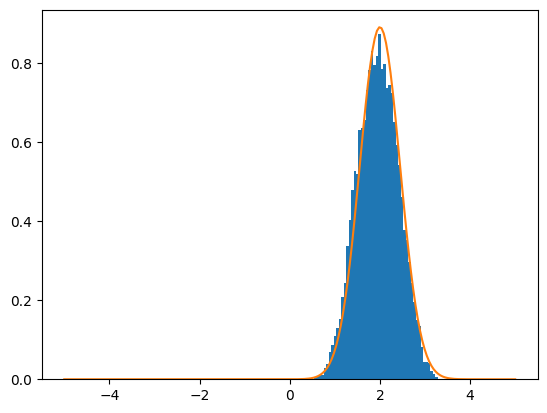

In [9]:
merging1 = chains_mala.flatten()

h = plt.hist(merging1, 50, density=True) # the last column; 50 is the number of bins that the histogram will use

t = np.linspace(-5, 5, 200)
y_values = []
for i in range(len(t)):
    y_values.append(np.exp(log_posterior(t[i], data)))  # Use data['data'] as argument

y_values = np.array(y_values)
plt.plot(t, y_values / Z[0])
#plt.plot(t, np.exp(log_posterior(t, data)) / Z[0]) # true density
plt.show()

In [10]:
# pip install tensorflow
# pip install tensorflow_probability
# pip install tensorflow-probability[tf]
import tensorflow as tf
import tensorflow_probability as tfp
from typing import Callable, Tuple

import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jrnd
from jax.flatten_util import ravel_pytree

In [11]:
def stein_disc(X, logprob_fn, beta=-1/2) -> Tuple:
    """Stein discrepancy with inverse multi-quadric kernel,
    i.e. (1 + (x - x')T(x - x')) ** beta
    returns U-Statistic (unbiased) and V-statistic (biased)
    """

    X = jax.tree_map(lambda x: x.reshape((-1,) + x.shape[2:]), X)
    if isinstance(X, dict):
        d = 0
        for name, x in X.items():
            s = x.shape
            if not s[1:]:
                d += 1
            else:
                d += s[1]
        T = s[0]
        sub = lambda x, x_: ravel_pytree(x)[0] - ravel_pytree(x_)[0]
        grad = lambda x: ravel_pytree(jax.grad(logprob_fn)(x))[0]
    else: 
        T, d = X.shape
        sub = lambda x, x_: x - x_
        grad = jax.grad(logprob_fn)
    beta = -beta

    # gradk = lambda diff, dot_prod: -2 * beta * (1 + dot_prod) ** (-beta - 1) * diff
    # gradgradk = lambda diff, dot_prod: -2 * beta * jnp.sum(-diff ** 2 * 2 * (-beta - 1) * (1 + dot_prod) ** (-beta - 2) - (1 + dot_prod) ** (-beta - 1))

    # def disc2(x, x_):
    #     diff = sub(x, x_)
    #     dot_prod = jnp.dot(diff, diff)
    #     dx = grad(x)
    #     dx_ = grad(x_)
    #     return (
    #         jnp.dot(dx, dx_) * (1 + dot_prod) ** (-beta)
    #         + jnp.dot(dx, -gradk(diff, dot_prod)) + jnp.dot(dx_, gradk(diff, dot_prod))
    #         + gradgradk(diff, dot_prod)
    #     )

    def disc(x, x_):
        diff = sub(x, x_)
        dot_prod = jnp.dot(diff, diff)
        dx = grad(x)
        dx_ = grad(x_)
        return (
            -4 * beta * (beta+1) * dot_prod / ((1 + dot_prod) ** (beta + 2))
            + 2 * beta * (d + jnp.dot(dx - dx_, diff)) / ((1 + dot_prod) ** (1 + beta))
            + jnp.dot(dx, dx_) / ((1 + dot_prod) ** beta)
        )

    _disc = jax.vmap(disc, (None, 0))
    # _disc2 = jax.vmap(disc2, (None, 0))
    # try:
    #     mc_sum = jax.vmap(_disc, (0, None))(X, X).sum()
    #     # mc_sum2 = jax.vmap(_disc2, (0, None))(X, X).sum()
    #     # print(mc_sum, mc_sum2)
    # except RuntimeError:
    mc_sum = jax.lax.map(lambda x: _disc(x, X).sum(), X).sum()
    return (mc_sum - jax.vmap(lambda x: disc(x, x))(X).sum()) / (T * (T-1)), mc_sum / T**2

def autocorrelation(x, axis=0):
    """
    Computes the autocorrelation of samples at dimension ``axis``.

    :param numpy.ndarray x: the input array.
    :param int axis: the dimension to calculate autocorrelation.
    :return: autocorrelation of ``x``.
    :rtype: numpy.ndarray
    """
    # Ref: https://en.wikipedia.org/wiki/Autocorrelation#Efficient_computation
    # Adapted from Stan implementation
    # https://github.com/stan-dev/math/blob/develop/stan/math/prim/mat/fun/autocorrelation.hpp
    N = x.shape[axis]
    M = _fft_next_fast_len(N)
    M2 = 2 * M

    # transpose axis with -1 for Fourier transform
    x = np.swapaxes(x, axis, -1)

    # centering x
    centered_signal = x - x.mean(axis=-1, keepdims=True)

    # Fourier transform
    freqvec = np.fft.rfft(centered_signal, n=M2, axis=-1)
    # take square of magnitude of freqvec (or freqvec x freqvec*)
    freqvec_gram = freqvec * np.conjugate(freqvec)
    # inverse Fourier transform
    autocorr = np.fft.irfft(freqvec_gram, n=M2, axis=-1)

    # truncate and normalize the result, then transpose back to original shape
    autocorr = autocorr[..., :N]
    # autocorr = autocorr / np.arange(N, 0.0, -1)
    with np.errstate(invalid="ignore", divide="ignore"):
        autocorr = autocorr / autocorr[..., :1] / 2
    return np.swapaxes(autocorr, axis, -1)

def _fft_next_fast_len(target):
    # find the smallest number >= N such that the only divisors are 2, 3, 5
    # works just like scipy.fftpack.next_fast_len
    if target <= 2:
        return target
    while True:
        m = target
        while m % 2 == 0:
            m //= 2
        while m % 3 == 0:
            m //= 3
        while m % 5 == 0:
            m //= 5
        if m == 1:
            return target
        target += 1

In [16]:
autoCorr1 = autocorrelation(merging1)
sum(autoCorr1)

0.25000000001097966

In [ ]:
def logpi_3(x):
    return np.log(0.5*norm.pdf(x, scale = 0.2) + 0.5*norm.pdf(x - 8, scale = 0.3))